In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from met_api import ArchivedMetAPI
import flask_data

In [ ]:
api = ArchivedMetAPI("noaa-sites.yaml")

In [ ]:
file = "https://gml.noaa.gov/aftp/data/hats/hcfcs/hcfc142b/flasks/HCFC142B_GCMS_flask.txt"
gml_df = flask_data.load_flask_data(file)

gml_df = (
    gml_df
    .assign(
        wind_spd=lambda d: pd.to_numeric(d["wind_spd"], errors="coerce"),
        wind_dir=lambda d: pd.to_numeric(d["wind_dir"], errors="coerce"),
    )
    .dropna(subset=["wind_spd", "wind_dir"])
    .loc[lambda d: d["wind_spd"].between(0, 100)]
)

# Filter out data before 2020-01-01
gml_df = gml_df.loc[gml_df['datetime_utc'] > pd.Timestamp("2020-01-01")]


In [ ]:
sites = ['brw','cgo','lef','hfm']

In [ ]:
day_cache = {}

def api_wind_for_ts(site, ts):
    if pd.isna(ts):
        return (pd.NA, pd.NA)
    
    lat, lon, _, _ = api.resolve_location(site, None, None)

    ts = pd.Timestamp(ts)
    if ts.tz is None:
        ts = ts.tz_localize("UTC")
    else:
        ts = ts.tz_convert("UTC")

    dt = ts.to_pydatetime()
    day_key = ts.date().isoformat()

    if day_key not in day_cache:
        day_cache[day_key] = api.fetch_hourly_wind(lat, lon, dt)

    times, ws, wd = day_cache[day_key]
    interpolated, nearest = api.interpolate_wind(times, ws, wd, dt)

    if interpolated is not None:
        _, _, spd, direction = interpolated
        return spd, direction

    # fallback if target isn't bracketed
    _, spd, direction = nearest
    return spd, direction

In [ ]:
for site in sites:
    gml_df[f"{site}_wind_spd"], gml_df[f"{site}_wind_dir"] = zip(*gml_df["datetime_utc"].apply(lambda ts: api_wind_for_ts(site, ts)))

In [34]:
alt = gml_df.loc[gml_df["site"] == "alt"]
    
vals = alt["datetime_utc"].apply(api_wind_for_ts)

alt["api_wind_spd"] = vals.str[0]
alt["api_wind_dir"] = vals.str[1]

alt.head()

/var/folders/jj/jnw_6dqj183bh1z9bhf6kf6w0000gq/T/ipykernel_43170/4012560184.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alt["api_wind_spd"] = vals.str[0]
/var/folders/jj/jnw_6dqj183bh1z9bhf6kf6w0000gq/T/ipykernel_43170/4012560184.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alt["api_wind_dir"] = vals.str[1]


,site,dec_date,yyyymmdd hhmmss,wind_dir,wind_spd,HCFC142B,HCFC142B_sd,datetime_utc,api_wind_spd,api_wind_dir
20,alt,1994.93629,19941208 1753,304.0,0.6,8.25,0.12,1994-12-08 17:53:00+00:00,2.681833,227.417168
21,alt,1995.03206,19950112 1651,352.0,3.7,8.07,0.16,1995-01-12 16:51:00+00:00,1.674500,331.400290
22,alt,1995.12817,19950216 1844,294.0,1.4,7.55,0.35,1995-02-16 18:44:00+00:00,1.507333,275.869042
23,alt,1995.24594,19950331 1827,207.0,8.4,8.17,0.09,1995-03-31 18:27:00+00:00,3.614000,192.000000
24,alt,1995.26189,19950406 1410,245.0,0.5,8.01,0.26,1995-04-06 14:10:00+00:00,1.590000,328.000000


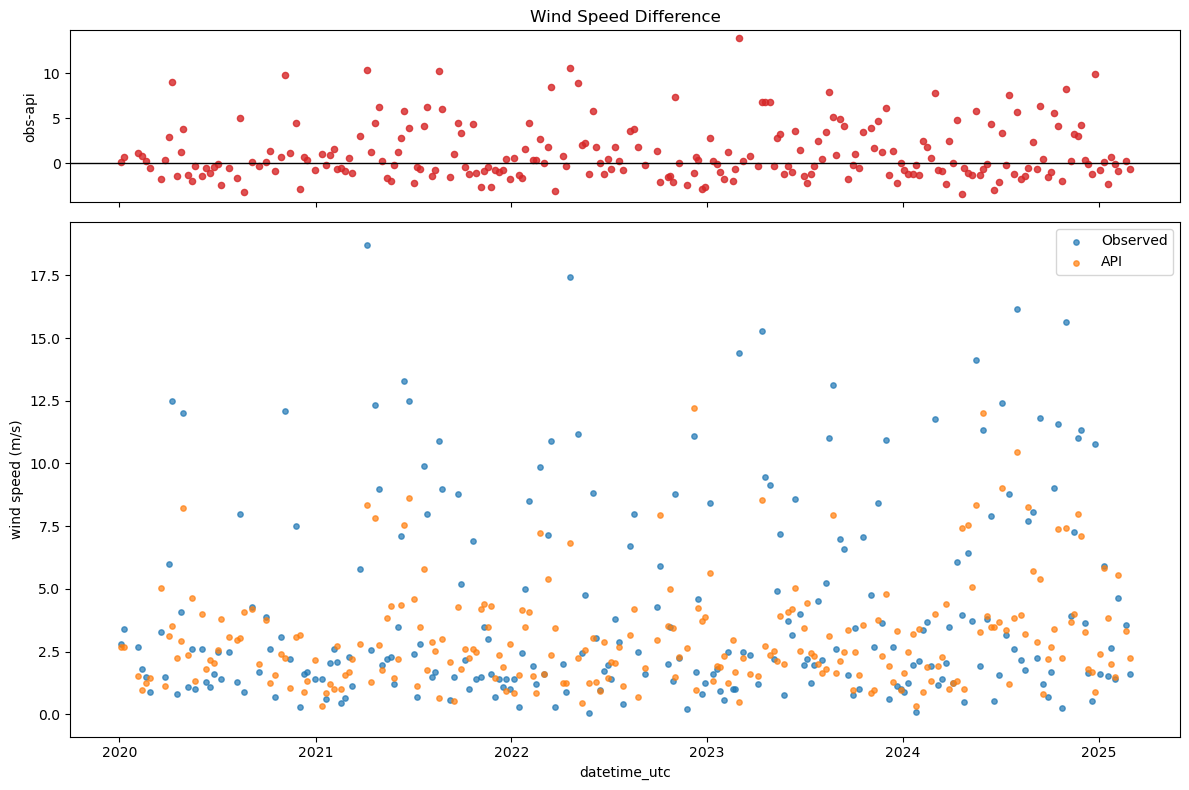

In [46]:
subset = (
    alt.loc[alt.datetime_utc > "2020-01-01", ["datetime_utc", "wind_spd", "api_wind_spd", "wind_dir", "api_wind_dir"]]
    .dropna()
    .copy()
)
subset["spd_diff"] = subset["wind_spd"] - subset["api_wind_spd"]
subset["dir_diff"] = subset["wind_dir"] - subset["api_wind_dir"]

fig, (ax_top, ax_main) = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [1, 3]}
)

# Top (1/4): difference
ax_top.scatter(subset["datetime_utc"], subset["spd_diff"], s=20, alpha=0.8, color="tab:red")
ax_top.axhline(0, color="black", lw=1)
ax_top.set_ylabel("obs-api")
ax_top.set_title("Wind Speed Difference")

# Bottom (3/4): main time series
ax_main.scatter(subset["datetime_utc"], subset["wind_spd"], s=15, alpha=0.7, label="Observed")
ax_main.scatter(subset["datetime_utc"], subset["api_wind_spd"], s=15, alpha=0.7, label="API")
ax_main.set_ylabel("wind speed (m/s)")
ax_main.set_xlabel("datetime_utc")
ax_main.legend()

plt.tight_layout()
plt.show()

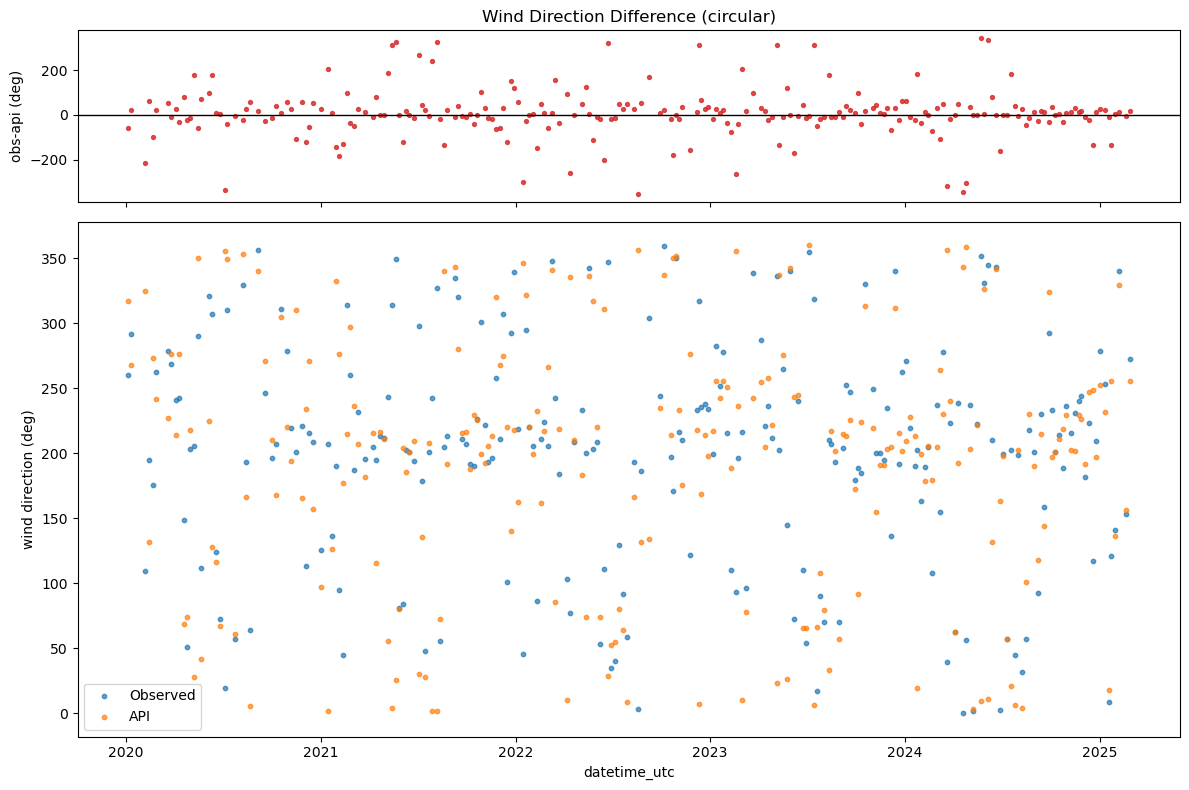

In [47]:
# Circular signed difference: obs - api, in degrees, range [-180, 180]
obs_rad = np.deg2rad(subset["wind_dir"].to_numpy())
api_rad = np.deg2rad(subset["api_wind_dir"].to_numpy())
#subset["dir_diff"] = np.rad2deg(np.arctan2(np.sin(obs_rad - api_rad), np.cos(obs_rad - api_rad)))
subset["dir_diff"] = np.cos(obs_rad) - np.cos(api_rad)  # Alternative: just use sine of the difference for a simpler metric

subset["dir_diff"] = subset["wind_dir"] - subset["api_wind_dir"]

fig, (ax_top, ax_main) = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [1, 3]}
)

# Top (1/4): circular difference
ax_top.scatter(subset["datetime_utc"], subset["dir_diff"], s=8, alpha=0.8, color="tab:red")
ax_top.axhline(0, color="black", lw=1)
ax_top.set_ylabel("obs-api (deg)")
ax_top.set_title("Wind Direction Difference (circular)")

# Bottom (3/4): main time series
ax_main.scatter(subset["datetime_utc"], subset["wind_dir"], s=10, alpha=0.7, label="Observed")
ax_main.scatter(subset["datetime_utc"], subset["api_wind_dir"], s=10, alpha=0.7, label="API")
ax_main.set_ylabel("wind direction (deg)")
ax_main.set_xlabel("datetime_utc")
ax_main.legend()

plt.tight_layout()
plt.show()

In [49]:
alt.to_csv("alt_wind_comparison.csv", index=False)

In [45]:
subset["spd_diff"].describe()

count    1086.000000
mean        0.918305
std         3.058093
min        -6.463000
25%        -0.966792
50%         0.173000
75%         1.963958
max        20.035667
Name: spd_diff, dtype: float64